## The following lines of code analysis the sensor time series data with following goals in mind:
* The data needs to be made forecasting ready
* The facilities manager wants to maintain temperature and co2 levels at given threshold.

### Dataset available:
* Indoor air quality data (iaq.json)
* Indoor air quality data (oaq.json)
* Sensor location data (floors.json)

In [240]:
# importing the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [241]:
# analysis of the iaq (indoor air quality) data

df = pd.read_json("iaq.json")
df_out = pd.read_json("oaq.json")
df_floor = pd.read_json("floors.json")
df.head()

,documentTime,temp,humidity,co2,sensor_id
0,2023-01-23T00:03:37.000Z,23.5,22,788,ENKZYW001792
1,2023-01-23T00:00:48.000Z,23.6,23,778,ENKZYW001804
2,2023-01-23T00:04:53.000Z,22.0,25,785,ENKZYW001882
3,2023-01-23T00:01:33.000Z,23.2,47,449,ENKZYW001856
4,2023-01-23T00:04:29.000Z,22.8,23,780,ENKZYW001848


### Data Analysis

In [242]:
# missing values check

pd.DataFrame({"Column Name":df.isna().sum().index,"No. of Missing Values":df.isna().sum().values})

,Column Name,No. of Missing Values
0,documentTime,0
1,temp,0
2,humidity,0
3,co2,0
4,sensor_id,0


##### - The dataset doesn't have any missing/NaN values -

In [243]:
# Statistical Analysis

df.describe()

,temp,humidity,co2
count,102629.000000,102629.000000,102629.000000
mean,23.518861,31.273412,565.377155
std,1.151765,5.090771,150.045277
min,13.000000,20.000000,411.000000
25%,22.900000,28.000000,446.000000
50%,23.700000,30.000000,508.000000
75%,24.300000,34.000000,652.000000
max,27.200000,62.000000,1378.000000


In [244]:
# datatype check

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102629 entries, 0 to 102628
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   documentTime  102629 non-null  object 
 1   temp          102629 non-null  float64
 2   humidity      102629 non-null  int64  
 3   co2           102629 non-null  int64  
 4   sensor_id     102629 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


##### - All but TimeStamp (documenTime) are in the right format -
* The documentTime needs to be converted from string object to a datetime date type
* In order to make this data a time series data, the documentTime columns needs to be turned into the index 

In [245]:
# datatype conversion of documentTime to timestamp

df["documentTime"] = pd.to_datetime(df["documentTime"])
df_out["documentTime"] = pd.to_datetime(df_out["documentTime"])

In [246]:
# conversion of time column to index. This converts the DataFrame into time series data

df.set_index('documentTime',inplace = True)
df_out.set_index('documentTime',inplace = True)

In [247]:
# updated data

df.head()

,temp,humidity,co2,sensor_id
documentTime,,,,
2023-01-23 00:03:37+00:00,23.5,22,788,ENKZYW001792
2023-01-23 00:00:48+00:00,23.6,23,778,ENKZYW001804
2023-01-23 00:04:53+00:00,22.0,25,785,ENKZYW001882
2023-01-23 00:01:33+00:00,23.2,47,449,ENKZYW001856
2023-01-23 00:04:29+00:00,22.8,23,780,ENKZYW001848


#### The sensors are installed at the ceiling height, and in order to get the desk level temperature, 1.5 is subtracted from that value.

In [248]:
pd.DataFrame({"Sensor Reading": df["temp"], "Temperature at desk height": df["temp"]-1.5})

,Sensor Reading,Temperature at desk height
documentTime,,
2023-01-23 00:03:37+00:00,23.5,22.0
2023-01-23 00:00:48+00:00,23.6,22.1
2023-01-23 00:04:53+00:00,22.0,20.5
2023-01-23 00:01:33+00:00,23.2,21.7
2023-01-23 00:04:29+00:00,22.8,21.3
...,...,...
2023-02-19 23:57:21+00:00,21.3,19.8
2023-02-19 23:55:53+00:00,21.8,20.3
2023-02-19 23:58:21+00:00,23.0,21.5


In [249]:
# Temp value correction
df["temp"] = df["temp"] - 1.5

#### The given data is for the whole day, but facilities manager is concerned about the working hours

#### **Assumption**: Working hours are 9 am to 5 pm

In [250]:
# keeping the data of working hours

df = df.loc[(df.index.hour >= 9) & (df.index.hour <= 16),]

In [251]:
df.head()

,temp,humidity,co2,sensor_id
documentTime,,,,
2023-01-23 09:03:38+00:00,21.7,20,838,ENKZYW001792
2023-01-23 09:00:49+00:00,21.9,21,848,ENKZYW001804
2023-01-23 09:03:22+00:00,21.7,47,449,ENKZYW001856
2023-01-23 09:04:30+00:00,21.4,22,852,ENKZYW001848
2023-01-23 09:04:18+00:00,22.0,22,885,ENKZYW001837


In [252]:
df.tail()

,temp,humidity,co2,sensor_id
documentTime,,,,
2023-02-19 16:57:21+00:00,20.6,36,432,ENKZYW001958
2023-02-19 16:55:53+00:00,20.4,35,483,ENKZYW001935
2023-02-19 16:58:20+00:00,21.9,34,436,ENKZYW001925
2023-02-19 16:59:00+00:00,22.8,32,447,ENKZYW001882
2023-02-19 16:59:00+00:00,22.5,31,437,ENKZYW001848


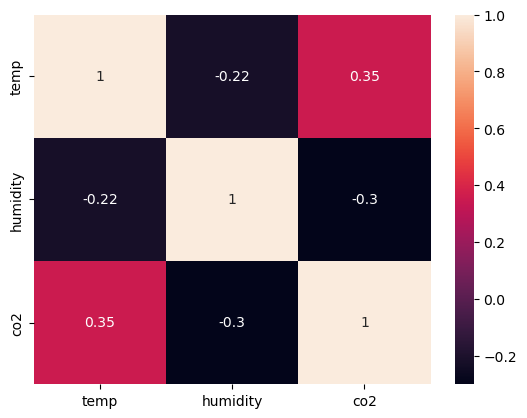

In [253]:
# Correlation Analysis

sns.heatmap(df.loc[:,["temp","humidity","co2"]].corr(),annot=True).figure.savefig("corr.png")

#### **Observation**: There not a significant correlation between given variables.

#### The floors dataset has the sensor locations for each floor. This is used to create separate dataframes for each floor

In [254]:
sensor_3F = [i['sensor_id'] for i in df_floor["sensors"][0]]
sensor_4F = [i['sensor_id'] for i in df_floor["sensors"][1]]

df_3F = df[df['sensor_id'].isin(sensor_3F)]
df_4F = df[df['sensor_id'].isin(sensor_4F)]

### Visualisations

In [212]:
def hourlyPlot(col,lim, df):
    '''
    Inputs:
        col - Column Name
        lim - Threshold Value
        df - DataFrame
    
    Output:
        Time Series plot averaged on hour
    '''
    
    plt.figure(figsize=(15,6))
    hourly_average = df[col].resample('H').mean()
    hourly_average = hourly_average.loc[(hourly_average.index.hour >= 9) & (hourly_average.index.hour <= 16),]
    plt.plot(hourly_average.index, hourly_average.values)
    plt.grid(True)
    if lim:
        plt.axhline(y = lim,color = 'r')
    plt.xlabel('Date')
    plt.ylabel(f'Hourly Average {col}')
    plt.title(f'Hourly {col} Trend with All Dates')
    plt.xticks(hourly_average.index.date,rotation=45);

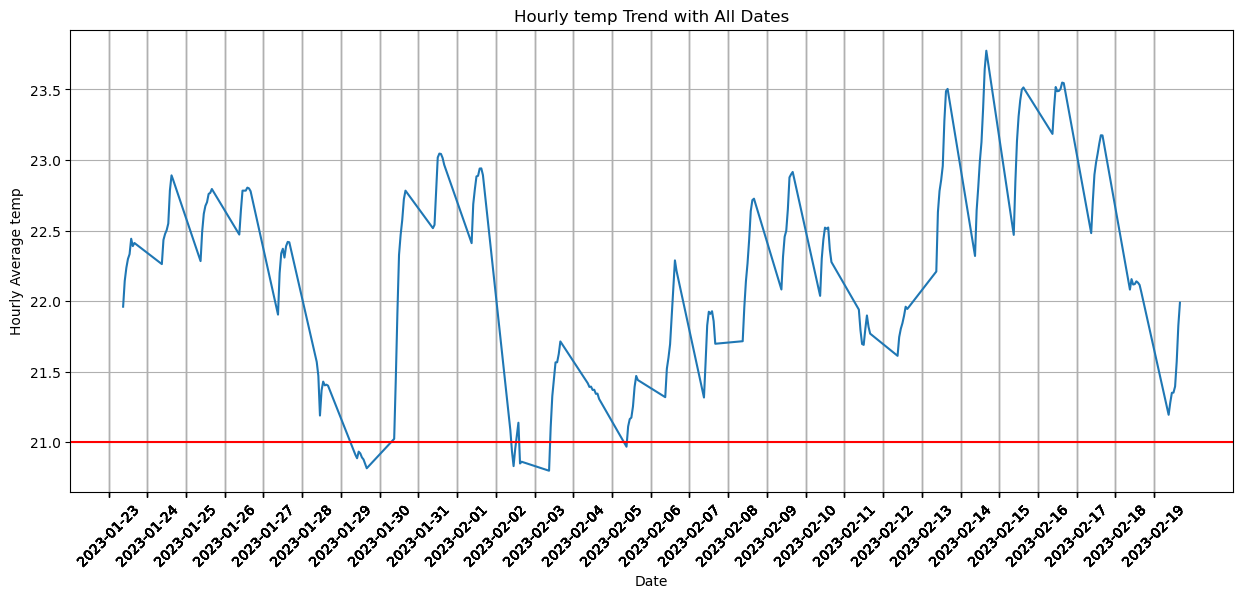

In [213]:
hourlyPlot("temp",21,df)

In [221]:
# Number of values below threhold

len(df.loc[(df["temp"] < 21),])

4153

#### **Observation**: Most of the temp values are above threshold, except two; one is a weekend, another is not. Since these are 12% of the total values, they can't be removed in order to avoid data loss.

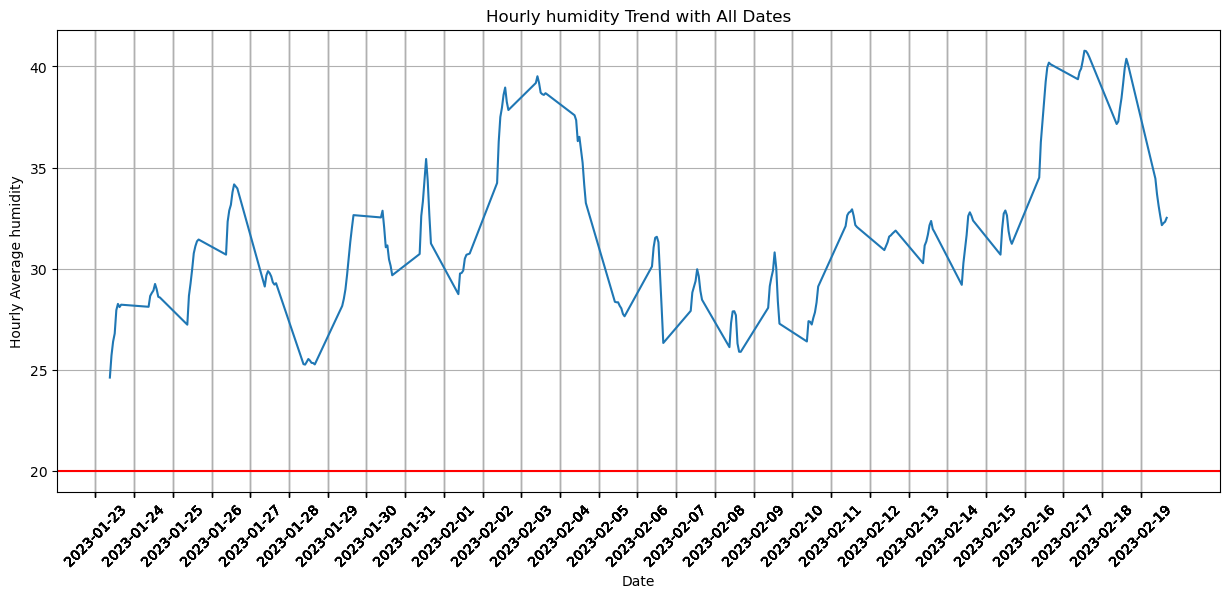

In [214]:
hourlyPlot("humidity",20,df)

#### **Observation**: All the values are above threshold, probably that's why humidity is not a primary concern

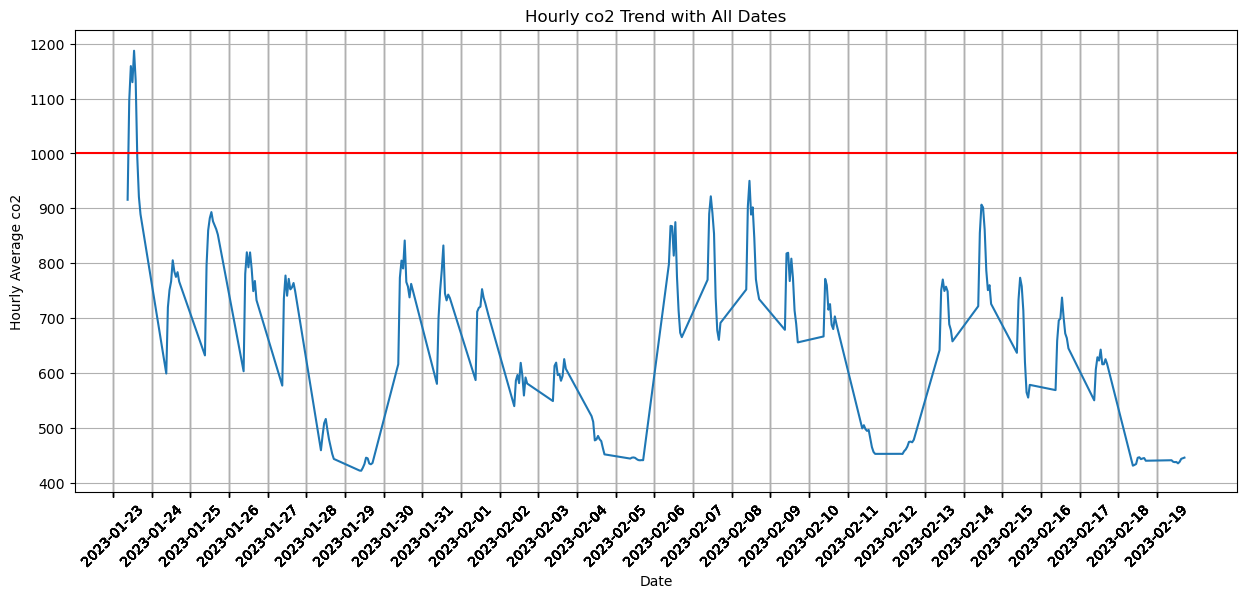

In [52]:
hourlyPlot("co2",1000,df)

#### **Observation**: The values follow a trend (drop on weekends), but an abrupt spike is seen in the beginning

Text(0, 0.5, 'CO2 levels')

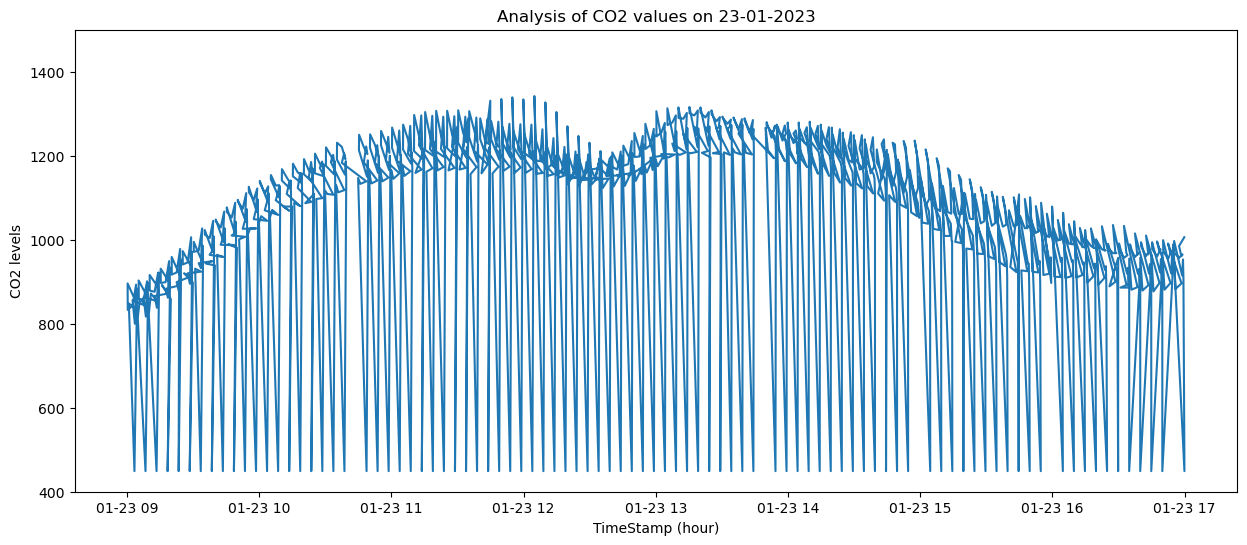

In [229]:
# Diving deeper to gain insight of the date 23-01-2023

plt.figure(figsize=(15,6))
plt.plot(df.loc[(df.index.day == 23),"co2"]);
plt.ylim(400,1500)
plt.title("Analysis of CO2 values on 23-01-2023")
plt.xlabel("TimeStamp (hour)")
plt.ylabel("CO2 levels")

#### **Observation**:
* The values are above threshold for almost the entire day. This could either be due to HVAC system failure or surge in headcount due to an event
* There is possibily a reset/default value

In [226]:
reset_val = df.loc[(df.index.day == 23),"co2"].min() #reset/default value
df.loc[(df["co2"] == reset_val),"co2"]

documentTime
2023-01-23 09:03:22+00:00    449
2023-01-23 09:08:23+00:00    449
2023-01-23 09:13:24+00:00    449
2023-01-23 09:18:25+00:00    449
2023-01-23 09:23:26+00:00    449
                            ... 
2023-02-19 15:09:36+00:00    449
2023-02-19 15:30:36+00:00    449
2023-02-19 15:50:36+00:00    449
2023-02-19 15:57:05+00:00    449
2023-02-19 16:30:36+00:00    449
Name: co2, Length: 539, dtype: int64

#### **Observation**:
* Reset/Default value is 449, which is occuring after every 5 minutes.
* This is 1.5% of the total data, so this could be removed

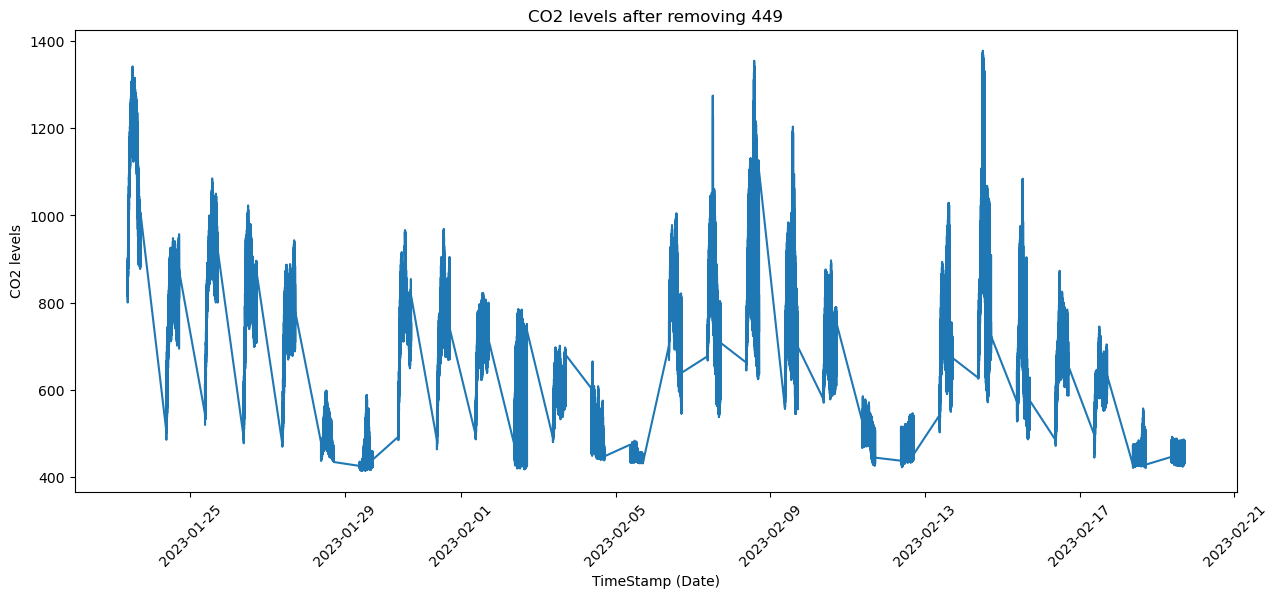

In [236]:
df_co2 = df.loc[~(df["co2"] == 449),"co2"] #separate data for forcasting CO2 levels

# The CO2 levels trend follows a repetitive pattern
df_co2.head()
plt.figure(figsize = (15,6))
plt.plot(df_co2)
plt.xticks(rotation = 45);
plt.title("CO2 levels after removing 449")
plt.xlabel("TimeStamp (Date)")
plt.ylabel("CO2 levels");

#### Now we can visually compare the temperature trend of each floor

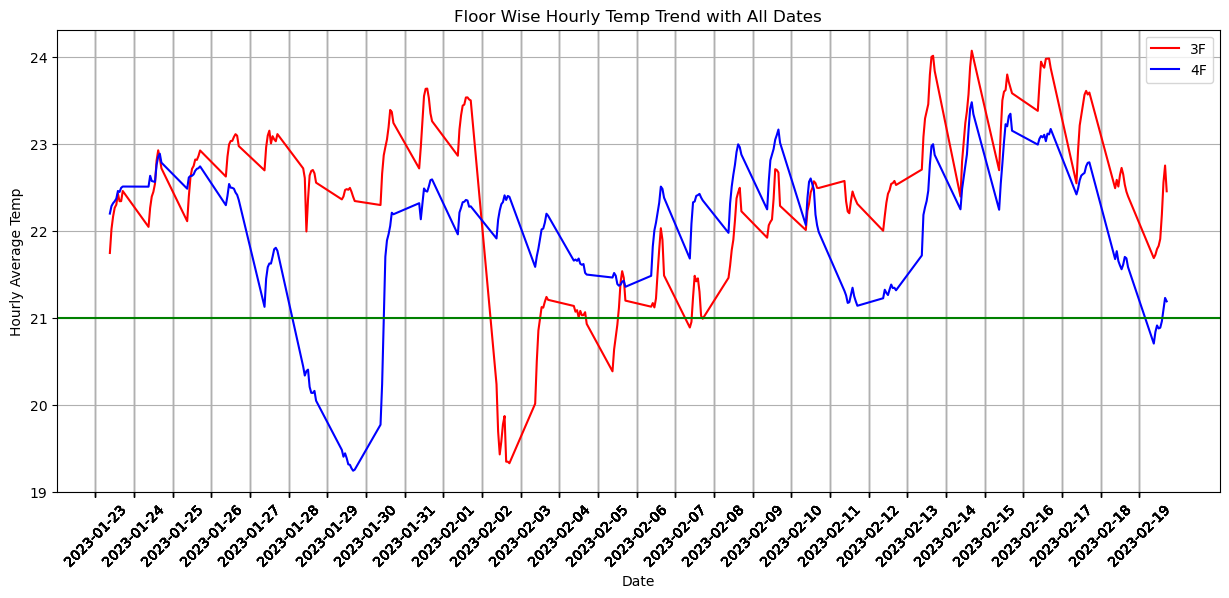

In [135]:
plt.figure(figsize=(15,6))
hourly_average = df_3F["temp"].resample('H').mean()
hourly_average_4f = df_4F["temp"].resample('H').mean()
hourly_average = hourly_average.loc[(hourly_average.index.hour >= 9) & (hourly_average.index.hour <= 17),]
hourly_average_4f = hourly_average_4f.loc[(hourly_average_4f.index.hour >= 9) & (hourly_average_4f.index.hour <= 17),]
plt.plot(hourly_average.index, hourly_average.values,color = 'r')
plt.plot(hourly_average_4f.index, hourly_average_4f.values,color = 'blue')
plt.grid(True)
plt.axhline(y = 21,color = 'g')
plt.xlabel('Date')
plt.ylabel(f'Hourly Average Temp')
plt.title(f'Floor Wise Hourly Temp Trend with All Dates')
plt.legend(["3F","4F"])
plt.xticks(hourly_average.index.date,rotation=45);

#### **Observation**: 
* Overall average temperature of 4th floor is lesser than 3rd, except in the middle part.
* 4th floor shows consistent dips on weekend, with on being very large (on 29-01-2023).
* 3rd floor shows a well maintained temperature throughout, except a sudden drop in 02-02-2023, which is a weekday.

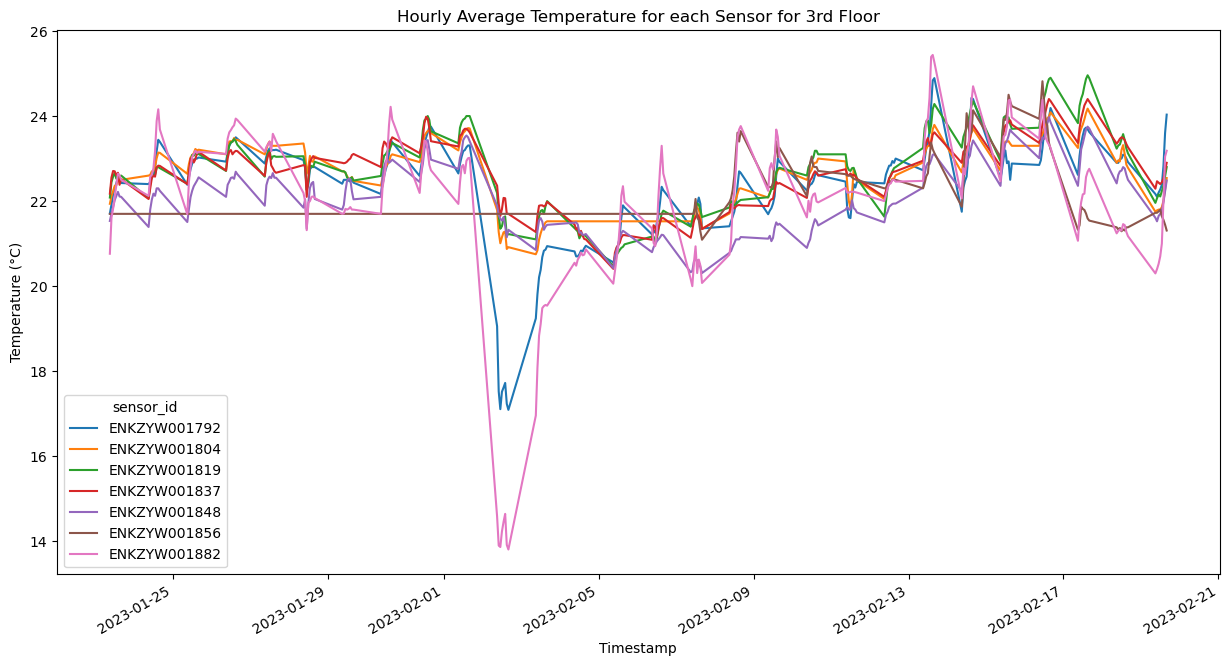

In [269]:
hourly_avg_temps = df_3F.groupby('sensor_id')['temp'].resample('H').mean().ffill()
hourly_avg_temps_unstacked = hourly_avg_temps.unstack(level='sensor_id')
hourly_avg_temps_unstacked = hourly_avg_temps_unstacked.loc[(hourly_avg_temps_unstacked.index.hour >= 9) & (hourly_avg_temps_unstacked.index.hour <= 16),]

hourly_avg_temps_unstacked.plot(figsize=(15, 8), title='Hourly Average Temperature for each Sensor for 3rd Floor')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.show()

#### The out of trend drop is shown by only two sensors. The area with these sensors could be checked. 

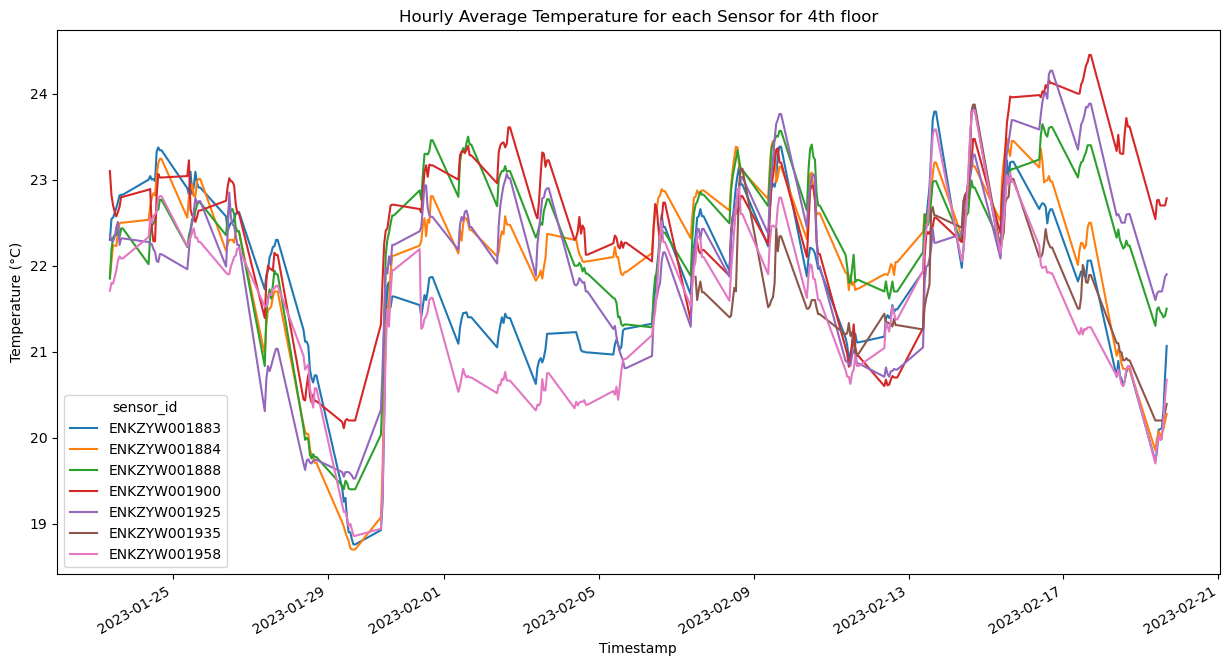

In [270]:
hourly_avg_temps = df_4F.groupby('sensor_id')['temp'].resample('H').mean().ffill()
hourly_avg_temps_unstacked = hourly_avg_temps.unstack(level='sensor_id')
hourly_avg_temps_unstacked = hourly_avg_temps_unstacked.loc[(hourly_avg_temps_unstacked.index.hour >= 9) & (hourly_avg_temps_unstacked.index.hour <= 17),]

hourly_avg_temps_unstacked.plot(figsize=(15, 8), title='Hourly Average Temperature for each Sensor for 4th floor')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.show()

#### Almost all the sensors are showing similar trends

### Outdoor Trends

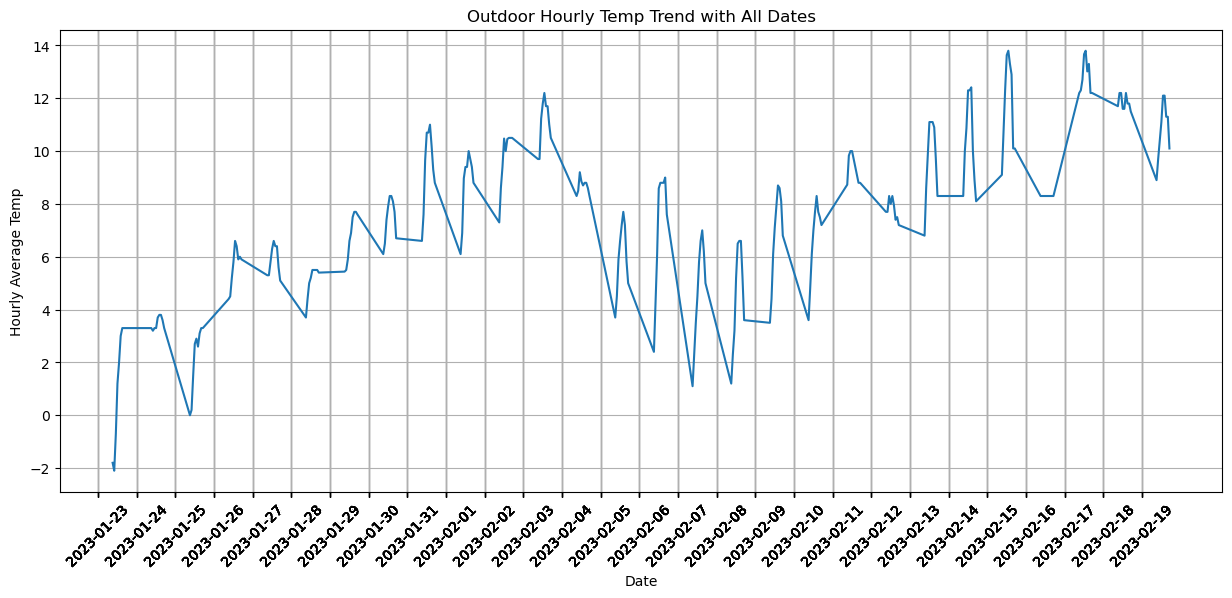

In [77]:
plt.figure(figsize=(15,6))
hourly_average_out = df_out["temperature"].resample('H').mean().bfill()
hourly_average_out = hourly_average_out.loc[(hourly_average_out.index.hour >= 9) & (hourly_average_out.index.hour <= 17),]
plt.plot(hourly_average_out.index, hourly_average_out.values)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel(f'Hourly Average Temp')
plt.title(f'Outdoor Hourly Temp Trend with All Dates')
plt.xticks(hourly_average_out.index.date,rotation=45);

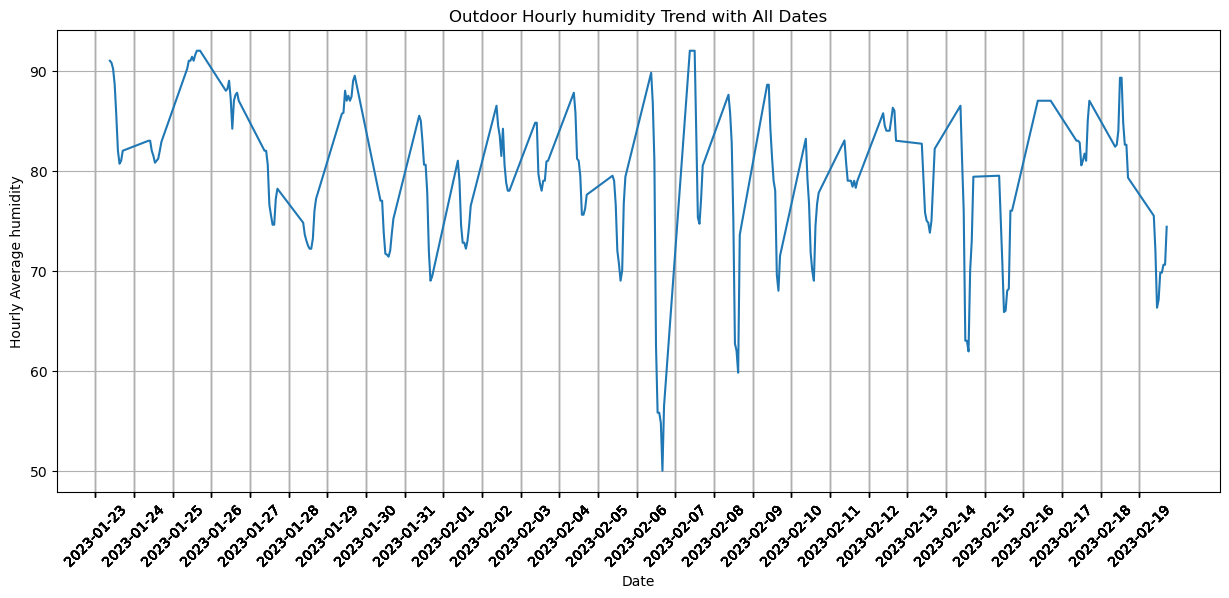

In [78]:
plt.figure(figsize=(15,6))
hourly_average_out = df_out["humidity"].resample('H').mean().bfill()
hourly_average_out = hourly_average_out.loc[(hourly_average_out.index.hour >= 9) & (hourly_average_out.index.hour <= 17),]
plt.plot(hourly_average_out.index, hourly_average_out.values)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel(f'Hourly Average humidity')
plt.title(f'Outdoor Hourly humidity Trend with All Dates')
plt.xticks(hourly_average_out.index.date,rotation=45);

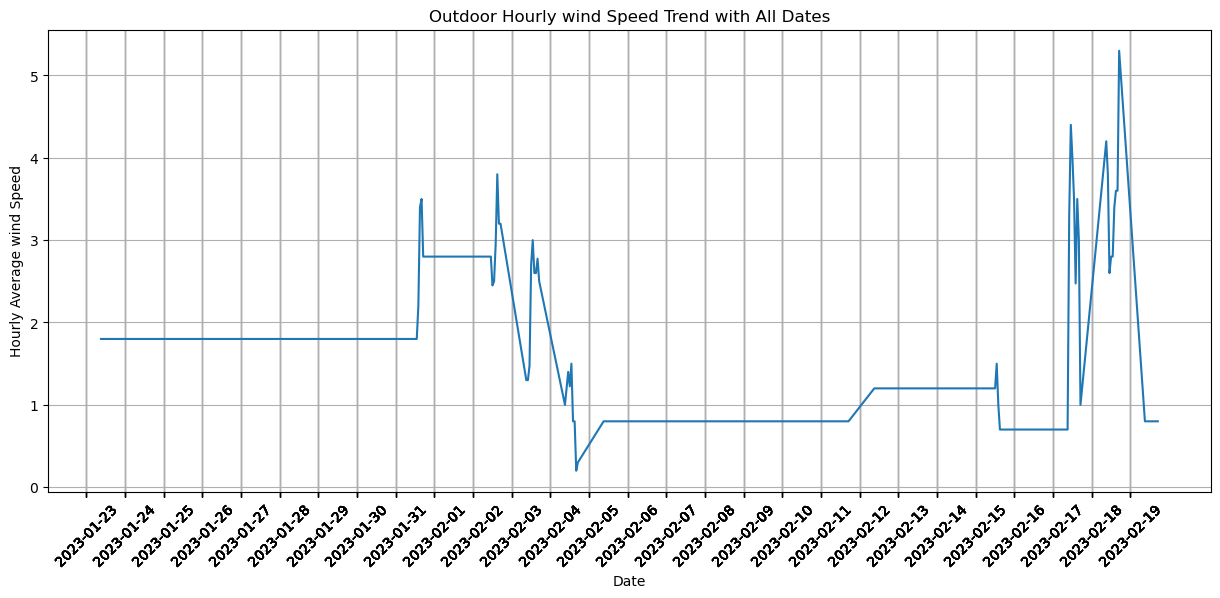

In [79]:
plt.figure(figsize=(15,6))
hourly_average_out = df_out["windSpeed"].resample('H').mean().bfill()
hourly_average_out = hourly_average_out.loc[(hourly_average_out.index.hour >= 9) & (hourly_average_out.index.hour <= 17),]
plt.plot(hourly_average_out.index, hourly_average_out.values)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel(f'Hourly Average wind Speed')
plt.title(f'Outdoor Hourly wind Speed Trend with All Dates')
plt.xticks(hourly_average_out.index.date,rotation=45);

#### Neither of the outdoor data visualisations show any noticeable picture that could explain the sudden dips in the indoor temperature.

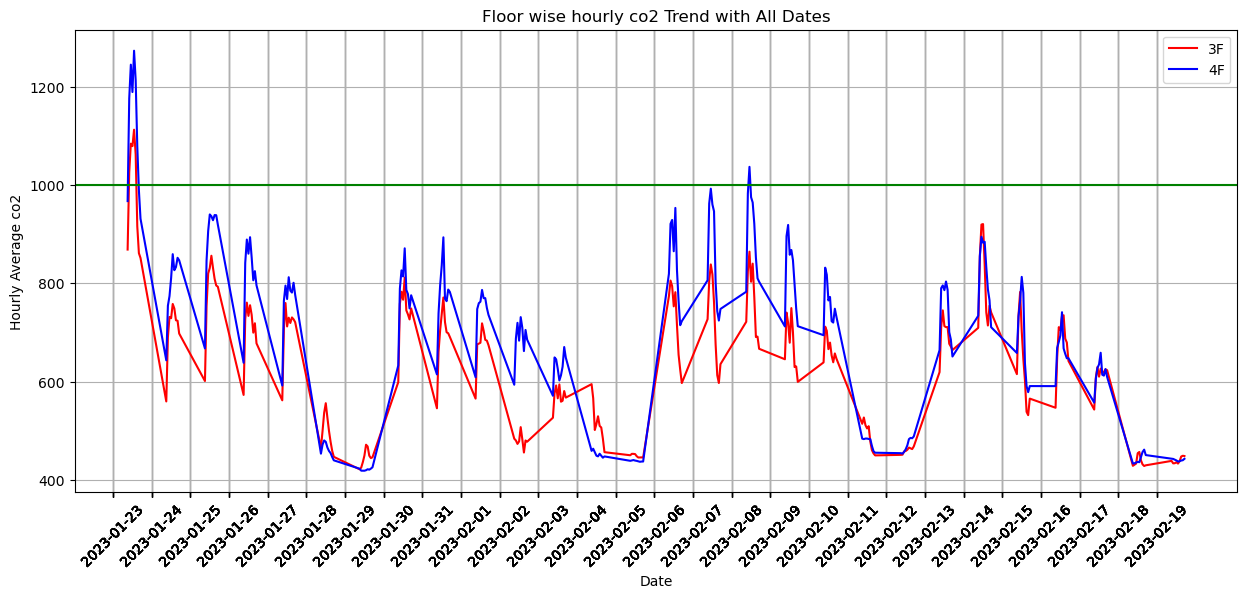

In [175]:
plt.figure(figsize=(15,6))
hourly_average = df_3F["co2"].resample('H').mean()
hourly_average_4f = df_4F["co2"].resample('H').mean()
hourly_average = hourly_average.loc[(hourly_average.index.hour >= 9) & (hourly_average.index.hour <= 17),]
hourly_average_4f = hourly_average_4f.loc[(hourly_average_4f.index.hour >= 9) & (hourly_average_4f.index.hour <= 17),]
plt.plot(hourly_average.index, hourly_average.values,color = 'r')
plt.plot(hourly_average_4f.index, hourly_average_4f.values,color = 'blue')
plt.grid(True)
plt.axhline(y = 1000,color = 'g')
plt.xlabel('Date')
plt.ylabel(f'Hourly Average co2')
plt.title(f'Floor wise hourly co2 Trend with All Dates')
plt.legend(["3F","4F"])
plt.xticks(hourly_average.index.date,rotation=45);

plt.savefig("co2.png")

#### The CO2 levels can be seen below the threshold, with a spike larger in 4th floor than 3rd on 23-01-2023. The CO2 data follows a trend where it drops on the weekends.

### Getting data forecasting ready

#### Stationarity Check

In [259]:
# Temperature
print(f'p-value for temperature: {adfuller(df["temp"])[1]}')

#CO2
print(f'p-value for co2: {adfuller(df_co2.values)[1]}')

p-value for temperature: 0.13945984773368375
p-value for co2: 0.0013852906896457782


#### p-values suggest temperature data is non stationary, while co2 data is stationary

#### This could be verified using moving average

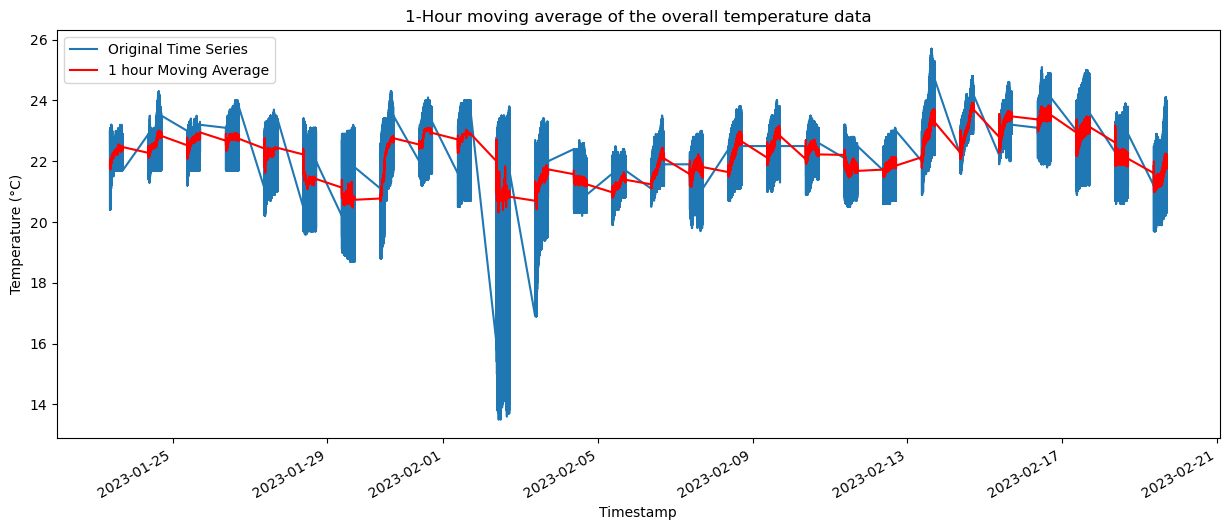

In [260]:
plt.figure(figsize=(15,6))
df['temp'].plot(label='Original Time Series')
df['temp'].rolling(window=12).mean().plot(label='1 hour Moving Average', color='red')
plt.legend()
plt.title('1-Hour moving average of the overall temperature data')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.show()

#### This could be fixed with the help of differencing. I began with first order differencing.

In [264]:
df_temp = df.drop("sensor_id",axis = 1)
df_temp.head()
df_temp["temp"] = df_temp["temp"].diff()
df_temp.dropna(inplace=True)

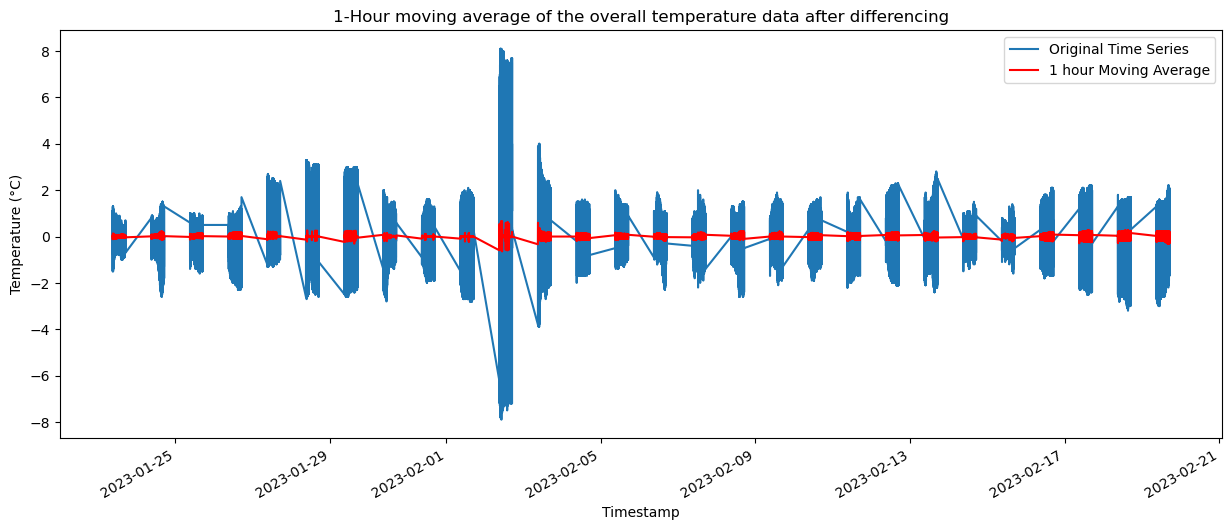

In [266]:
# Moving Average after differencing

plt.figure(figsize=(15,6))
df_temp['temp'].plot(label='Original Time Series')
df_temp['temp'].rolling(window=12).mean().plot(label='1 hour Moving Average', color='red')
plt.legend()
plt.title('1-Hour moving average of the overall temperature data after differencing')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')

plt.show()

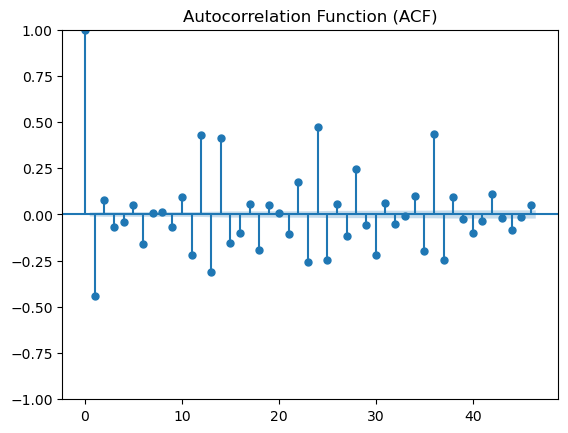

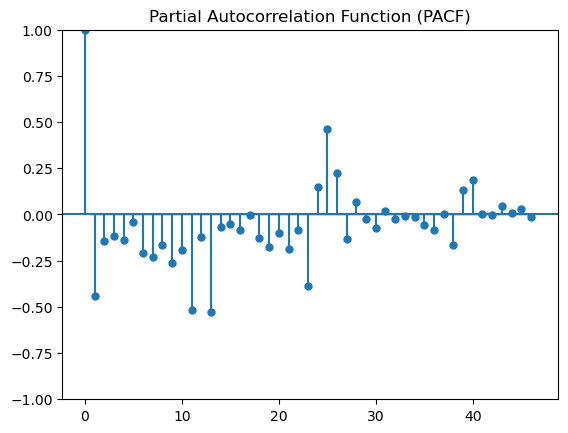

In [268]:
# Following ACF and PACF plots can be used to find the p,d,q values for the time series forecasting models

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#lags are kept as default

plot_acf(df_temp['temp'])
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(df_temp['temp'])
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


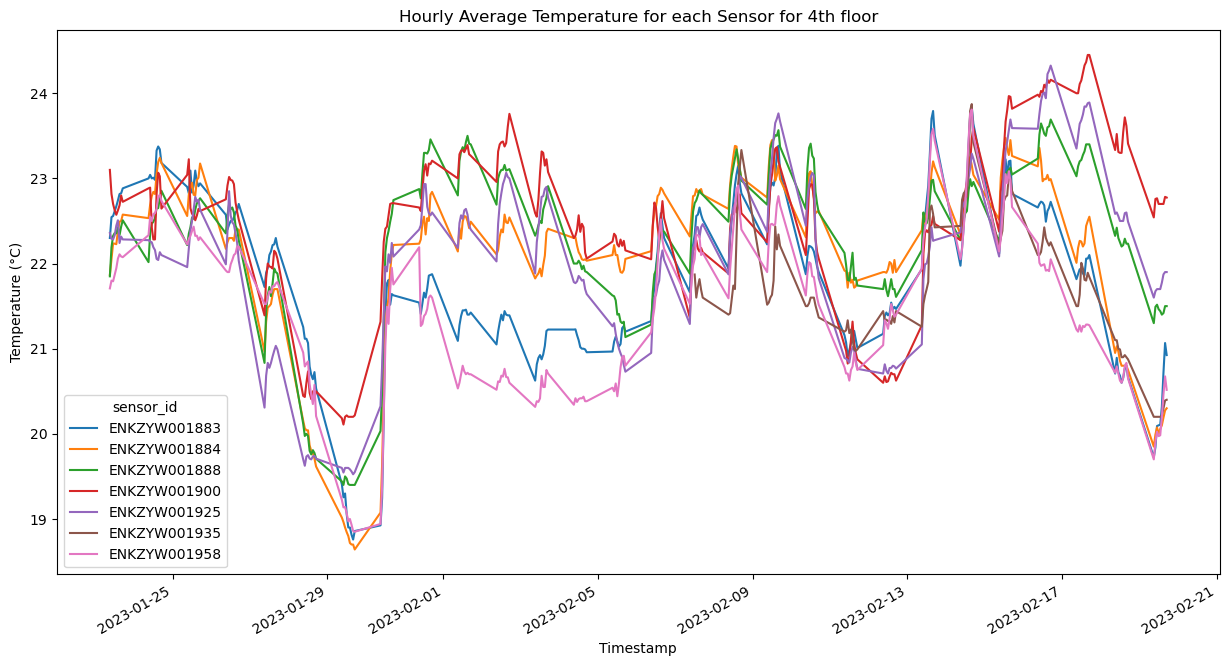

Final DataFrames that could be used for forecasting temperature and CO2 levels are **df_temp** and **df_co2** respectively.